# Roi Hezkiyahu
## USL EX4

imports

In [605]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import MinMaxScaler

guidelines:
Download mnist background images.zip and mnist background random.zip from
https://www.iro.umontreal.ca/∼lisa/icml2007data/.
For sections 1-3 Load mnist background random and subset a 2000 images of the handwritten digits
3 and 8.

In [606]:
def plot_image_grid(images, rows, cols, titles = None, gray = True):
    fig, axs = plt.subplots(rows, cols, figsize=(16, 4))
    for i, ax in enumerate(axs.flat):
        if gray:
            ax.imshow(images[i], cmap = "gray")
        else:
            ax.imshow(images[i])
        if not isinstance(titles,type(None)):
            ax.set_title(titles[i])
    plt.tight_layout()
    plt.show()

# Q1

Use k-means to cluster the data and evaluate the clustering accuracy and Normalized Mutual
Information (NMI) of the result.

In [607]:
def read_amat(file_path):
    X = np.loadtxt(file_path)
    return X[:,:784], X[:, 784]
X_bg_tr, y_bg_tr = read_amat("mnist_background_random_test.amat")

In [608]:
np.random.seed(1)
def subset_by_y(X,y, subset = [3,8], n_obs = None, inds = None):
    valid_obs = np.isin(y, subset)
    X_subset = X[valid_obs]
    y_subset = y[valid_obs]
    if not isinstance(n_obs, type(None)):
        if isinstance(inds, type(None)):
            inds = np.array([])
            for i in subset:
                rand_ind_for_subset = np.random.choice(np.where(y_subset==i)[0],n_obs//len(subset),replace = False)
                inds = np.append(inds, rand_ind_for_subset)
            inds = inds.astype(int)
        X_subset = X_subset[inds]
        y_subset = y_subset[inds]
    return X_subset, y_subset, inds
X_bg_tr_3_8_sub, y_bg_tr_3_8_sub, inds = subset_by_y(X_bg_tr,y_bg_tr, subset = [3,8], n_obs = 4000)

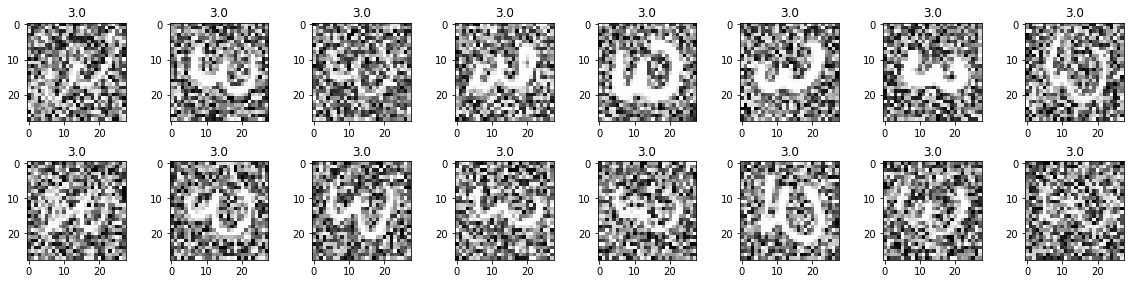

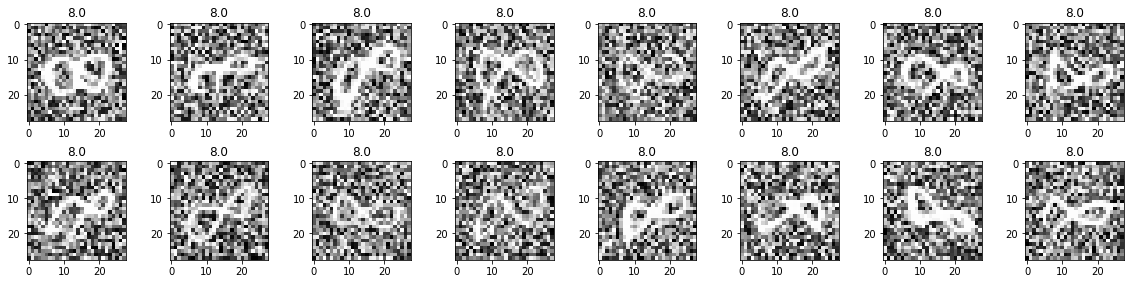

In [609]:
# see that the data loaded ok
plot_image_grid(X_bg_tr_3_8_sub.reshape(-1,28,28), 2, 8, titles = y_bg_tr_3_8_sub, gray = True)
plot_image_grid(X_bg_tr_3_8_sub.reshape(-1,28,28)[-16:], 2, 8, titles = y_bg_tr_3_8_sub[-16:], gray = True)

In [610]:
def cluster_and_nmi(X, y_true, k = 2,random_state=1):
    kmenas = KMeans(k,random_state=random_state)
    clusters = kmenas.fit_predict(X)
    print("NMI score:", np.round(normalized_mutual_info_score(y_true,clusters),4))
    print("clustring accuracy: ", np.mean(y_true == clusters))
cluster_and_nmi(X_bg_tr_3_8_sub, (y_bg_tr_3_8_sub==8).astype(int))

NMI score: 0.3036
clustring accuracy:  0.81025


# Q2

Compute the Laplacian Score (LS explained in Lecture 7) for each pixel. Then use ”imshow”
to present the LS for each pixel as a 28 × 28 image (same as the original MNIST images).

In [611]:
def compute_laplacian_scores(X, sigma = np.sqrt(1/2)):
    D = euclidean_distances(X)
    K = np.exp(-D/(2*sigma**2))
    S = np.sum(K,axis = 1)
    L = np.diag(S) - K
    features_norm = np.sum(np.square(X), axis = 0)
    normalized_matrix = X/features_norm
    laplacian_scores = []
    for i in range(normalized_matrix.shape[1]):
        laplacian_scores.append(normalized_matrix[:,i].T @ L @ normalized_matrix[:,i])
    return laplacian_scores

In [612]:
laplacian_scores = compute_laplacian_scores(X_bg_tr_3_8_sub)

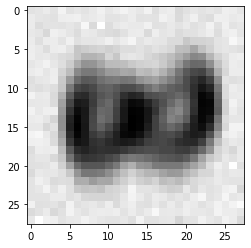

In [613]:
laplacian_img = np.array(laplacian_scores).reshape(28,28)
plt.imshow(laplacian_img, cmap = "gray")
plt.show()

# Q3

Select only the 200 smoothest features based on the Laplacian Score and apply k-means to
the selected features. Evaluate the clustering accuracy and Normalized Mutual Information
(NMI) of the result. Did the performance improve?

In [614]:
n_features = 200
feature_number = list(range(len(laplacian_scores)))
top_features = np.array(sorted(zip(np.array(laplacian_scores), feature_number)))[:n_features,1].astype(int)

In [615]:
cluster_and_nmi(X_bg_tr_3_8_sub[:,top_features], (y_bg_tr_3_8_sub==3).astype(int))

NMI score: 0.3209
clustring accuracy:  0.81875


we can see a little improvment in the NMI score and clustring accuracy

# Q4

Load mnist background images and subset a 2000 images of the handwritten digits 3 and 8.
Use Canonical Correlation Analysis (CCA) to embed the coupled data-set into a 2 dimensional
space. Visualize the embedding and use the labels of the samples as the color coding for
each sample. Clarification: $X \in R^{784×4000}$ are samples from mnist background random and
$Y \in R^{784×4000}$ are samples from mnist background images, where the first 2000 samples
correspond to 3s and the rest to 8s. Then, project X and Y into 2 dimensional spaces using
CCA and present the samples in both projected spaces.

In [616]:
X_tr, y_tr = read_amat("mnist_background_images_test.amat")

In [617]:
X_tr_3_8_sub, y_tr_3_8_sub, inds = subset_by_y(X_tr,y_tr, subset = [3,8], n_obs = 4000)

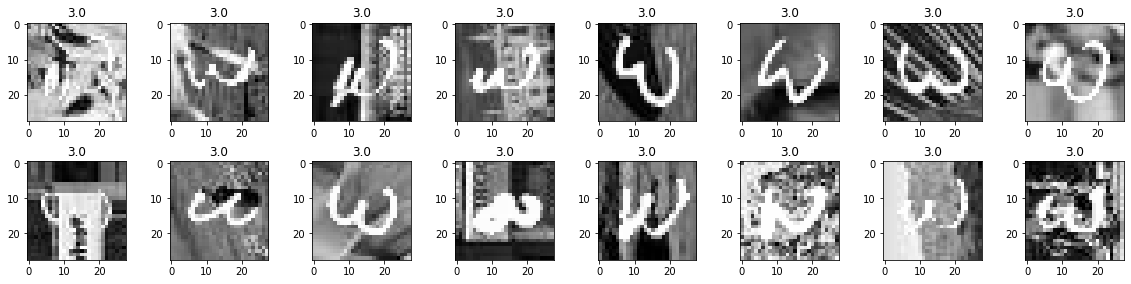

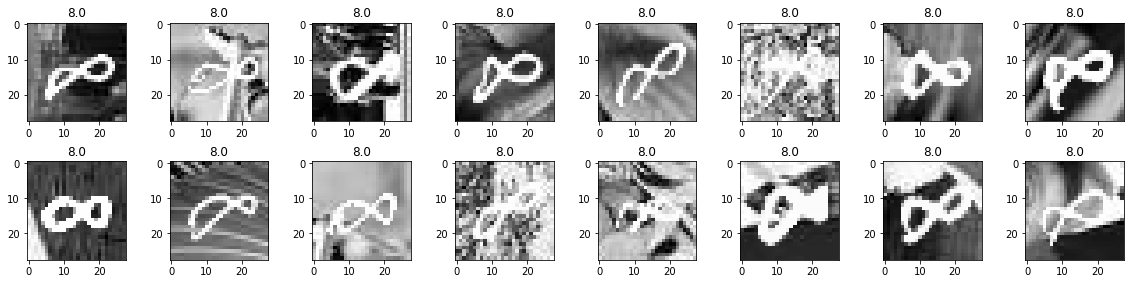

In [618]:
# see that the data loaded ok
plot_image_grid(X_tr_3_8_sub.reshape(-1,28,28), 2, 8, titles = y_tr_3_8_sub, gray = True)
plot_image_grid(X_tr_3_8_sub.reshape(-1,28,28)[-16:], 2, 8, titles = y_tr_3_8_sub[-16:], gray = True)

In [619]:
scaler = MinMaxScaler()
cca = CCA(n_components=2,max_iter=2000)
X_emb, X_bg_emb = cca.fit_transform(scaler.fit_transform(X_tr_3_8_sub), scaler.fit_transform(X_bg_tr_3_8_sub))

C:\Users\Nir\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Nir\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


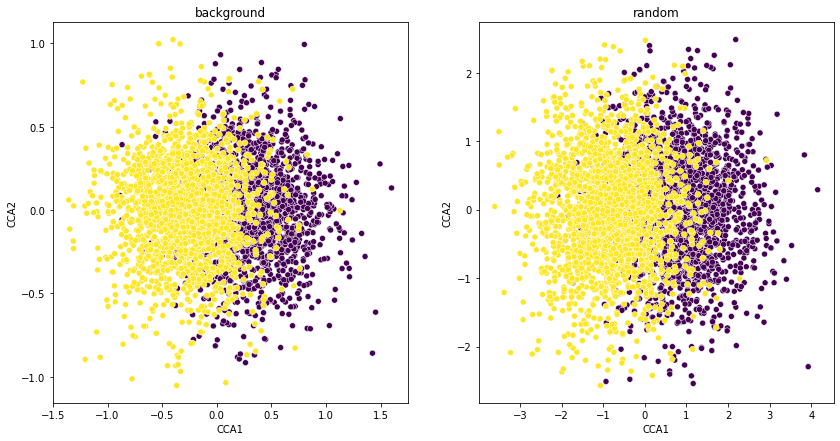

In [620]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize = (14,7))

sns.scatterplot(X_emb[:,0], X_emb[:,1], ax = ax1,c = y_tr_3_8_sub)
ax1.set_title("background")
ax1.set_ylabel("CCA2")
ax1.set_xlabel("CCA1")
sns.scatterplot(X_bg_emb[:,0], X_bg_emb[:,1], ax = ax2,c = y_bg_tr_3_8_sub)
ax2.set_title("random")
ax2.set_ylabel("CCA2")
ax2.set_xlabel("CCA1")
plt.show()

C:\Users\Nir\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Nir\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


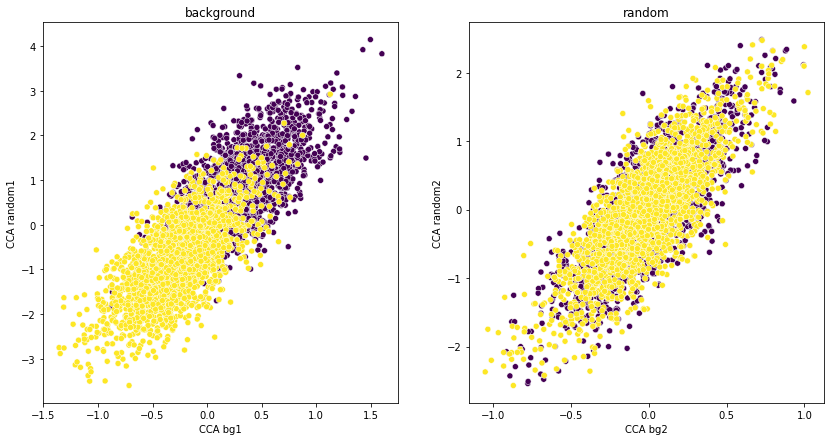

In [621]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize = (14,7))

sns.scatterplot(X_emb[:,0], X_bg_emb[:,0], ax = ax1,c = y_tr_3_8_sub)
ax1.set_title("background")
ax1.set_ylabel("CCA random1")
ax1.set_xlabel("CCA bg1")
sns.scatterplot(X_emb[:,1], X_bg_emb[:,1], ax = ax2,c = y_bg_tr_3_8_sub)
ax2.set_title("random")
ax2.set_ylabel("CCA random2")
ax2.set_xlabel("CCA bg2")
plt.show()

# Q5

What is the correlation between samples in the low dimensional space? Compute the total
correlation. That is the sum of correlation over all (2) coordinates.

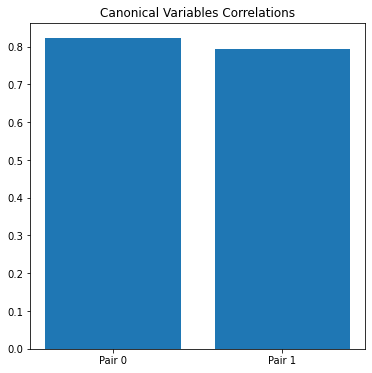

In [622]:
corrcoef0 = np.corrcoef(X_emb[:, 0], X_bg_emb[:, 0])[0, 1]
corrcoef1 = np.corrcoef(X_emb[:, 1], X_bg_emb[:, 1])[0, 1]

x_bar_plot = ["Pair 0", "Pair 1"]
y_bar_plot = [corrcoef0, corrcoef1]

plt.figure(figsize=(6,6))
plt.title("Canonical Variables Correlations")
plt.bar(x_bar_plot, y_bar_plot)
plt.show()

In [623]:
print("total correlation is: ", np.sum(y_bar_plot))

total correlation is:  1.6157104375254896


# Q6

Apply k-means to the combined 4 dimensional CCA space. Evaluate the clustering accuracy
and Normalized Mutual Information (NMI) of the result. Did the performance improve?

In [624]:
X_comb = np.concatenate([X_emb,X_bg_emb],axis =1)
cluster_and_nmi(X_comb, (y_tr_3_8_sub==8).astype(int))

NMI score: 0.3289
clustring accuracy:  0.824


it hasn improved a little

# Q7

Is the number of coordinates used here in the CCA space optimal? If not, can you suggest
an unsupervised (without using the image label) way to select the dimension of the CCA
embedding d that would preserve more of the shared information (across X and Y ).

- we cant say for sure if it is optimal or not, but it is probably not because we can see that the correlation is high in both axis and we will probably see that in the third axis the correlation is still high
- we can take a look at the next components correlations and use the elbow rule to choose d

In [630]:
scaler = MinMaxScaler()
n_components = 100
cca_large = CCA(n_components=n_components,max_iter=2000)
X_emb_large, X_bg_emb_large = cca_large.fit_transform(scaler.fit_transform(X_tr_3_8_sub), scaler.fit_transform(X_bg_tr_3_8_sub))

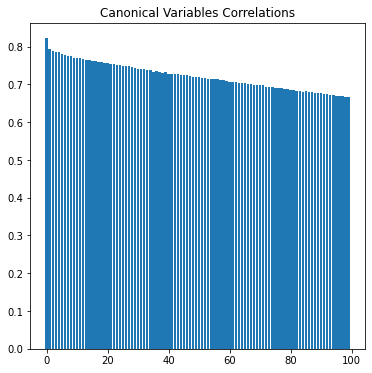

In [631]:
y_bar_plot = [np.corrcoef(X_emb_large[:, i], X_bg_emb_large[:, i])[0, 1] for i in range(n_components)]
x_bar_plot = [i for i in range(n_components)]


plt.figure(figsize=(6,6))
plt.title("Canonical Variables Correlations")
plt.bar(x_bar_plot, y_bar_plot)
plt.show()

In [632]:
X_comb = np.concatenate([X_emb_large,X_bg_emb_large],axis =1)
cluster_and_nmi(X_comb, (y_tr_3_8_sub==8).astype(int))

NMI score: 0.3551
clustring accuracy:  0.8355


we can see that it indeed improved the results, it's not the elbow yet (running it for all components takes a long time)